In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('Heartbeat_Sounds'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Heartbeat_Sounds/set_a.csv
Heartbeat_Sounds/set_a_timing.csv
Heartbeat_Sounds/set_b.csv
Heartbeat_Sounds/set_a/artifact__201012172012.wav
Heartbeat_Sounds/set_a/artifact__201105040918.wav
Heartbeat_Sounds/set_a/artifact__201105041959.wav
Heartbeat_Sounds/set_a/artifact__201105051017.wav
Heartbeat_Sounds/set_a/artifact__201105060108.wav
Heartbeat_Sounds/set_a/artifact__201105061143.wav
Heartbeat_Sounds/set_a/artifact__201105190800.wav
Heartbeat_Sounds/set_a/artifact__201105280851.wav
Heartbeat_Sounds/set_a/artifact__201106010559.wav
Heartbeat_Sounds/set_a/artifact__201106010602.wav
Heartbeat_Sounds/set_a/artifact__201106021541.wav
Heartbeat_Sounds/set_a/artifact__201106030612.wav
Heartbeat_Sounds/set_a/artifact__201106031558.wav
Heartbeat_Sounds/set_a/artifact__201106040722.wav
Heartbeat_Sounds/set_a/artifact__201106040933.wav
Heartbeat_Sounds/set_a/artifact__201106040947.wav
Heartbeat_Sounds/set_a/artifact__201106041452.wav
Heartbeat_Sounds/set_a/artifact__201106050353.wav
Heartbeat_So

In [3]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.layers import Dense, Dropout, Activation, Flatten

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Flatten

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
dataset = []
for folder in ["Heartbeat_Sounds/set_a/**","Heartbeat_Sounds/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        
                        dataset.append({
                                "filename": filename,
                                "label": label,
                                "offset": offset
                            })
                       
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 168 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1441 non-null   object 
 1   label     1441 non-null   object 
 2   offset    1441 non-null   float64
dtypes: float64(1), object(2)
memory usage: 45.0+ KB


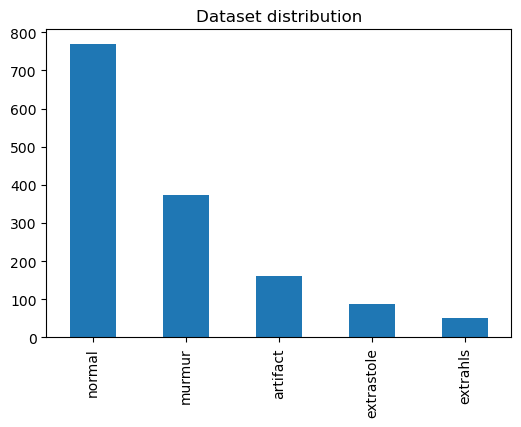

In [5]:
plt.figure(figsize=(6,4))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [6]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1152
Test: 289


In [7]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [8]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 289/289 [00:23<00:00, 12.32it/s]

X train: (1152, 40, 130)
X test: (289, 40, 130)


In [9]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train),
                                        y = y_train )

In [10]:
from tensorflow.keras.utils import to_categorical

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1152, 40, 130, 1)
Y train: (1152, 5)
X test: (289, 40, 130, 1)
Y test: (289, 5)


In [11]:

# Assuming `x_train` is your training data with the shape (batch_size, timesteps, features)
# and `encoder.classes_` is an array of your target classes

model = Sequential()

# Add LSTM layers
# Note that 'return_sequences=True' is set on all but the last LSTM layer to ensure that
# each LSTM layer passes on a sequence to the next layer, rather than just the final output
model.add(LSTM(32, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

# The last LSTM layer returns only the final step of the sequence
model.add(LSTM(256))
model.add(Dropout(0.5))

# Add a Dense layer with a softmax activation to classify the outputs
model.add(Dense(len(encoder.classes_), activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 32)            20864     
                                                                 
 dropout (Dropout)           (None, 40, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 64)            24832     
                                                                 
 dropout_1 (Dropout)         (None, 40, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40, 128)           98816     
                                                                 
 dropout_2 (Dropout)         (None, 40, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)              

In [12]:
 from tensorflow import keras
adam = keras.optimizers.Adam(1e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [14]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/300
9/9 [==============================] - 6s 696ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 3.0749 - val_accuracy: 0.6125
Epoch 2/300
9/9 [==============================] - 6s 716ms/step - loss: 0.0098 - accuracy: 0.9991 - val_loss: 2.9516 - val_accuracy: 0.6055
Epoch 3/300
9/9 [==============================] - 5s 595ms/step - loss: 0.0022 - accuracy: 0.9991 - val_loss: 2.9483 - val_accuracy: 0.6159
Epoch 4/300
9/9 [==============================] - 5s 569ms/step - loss: 8.1173e-04 - accuracy: 1.0000 - val_loss: 3.0283 - val_accuracy: 0.6159
Epoch 5/300
9/9 [==============================] - 6s 685ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 3.0471 - val_accuracy: 0.6471
Epoch 6/300
9/9 [==============================] - 5s 581ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.0665 - val_accuracy: 0.6436
Epoch 7/300
9/9 [==============================] - 5s 566ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 3.0488 - val_accuracy: 0.6194
Epoch 8/3

9/9 [==============================] - 7s 759ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 2.5685 - val_accuracy: 0.6401
Epoch 59/300
9/9 [==============================] - 6s 689ms/step - loss: 0.0103 - accuracy: 0.9974 - val_loss: 2.7422 - val_accuracy: 0.6194
Epoch 60/300
9/9 [==============================] - 6s 629ms/step - loss: 0.0110 - accuracy: 0.9974 - val_loss: 2.8596 - val_accuracy: 0.6125
Epoch 61/300
9/9 [==============================] - 7s 752ms/step - loss: 0.0063 - accuracy: 0.9974 - val_loss: 2.8913 - val_accuracy: 0.6090
Epoch 62/300
9/9 [==============================] - 7s 753ms/step - loss: 0.0074 - accuracy: 0.9983 - val_loss: 2.9171 - val_accuracy: 0.6194
Epoch 63/300
9/9 [==============================] - 9s 998ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 2.7536 - val_accuracy: 0.6194
Epoch 64/300
9/9 [==============================] - 9s 991ms/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 2.7164 - val_accuracy: 0.6263
Epoch 65/300
9/9 [=

9/9 [==============================] - 7s 794ms/step - loss: 0.0214 - accuracy: 0.9965 - val_loss: 2.7178 - val_accuracy: 0.6263
Epoch 116/300
9/9 [==============================] - 7s 847ms/step - loss: 0.0045 - accuracy: 0.9983 - val_loss: 2.8104 - val_accuracy: 0.6332
Epoch 117/300
9/9 [==============================] - 13s 1s/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 2.9139 - val_accuracy: 0.6298
Epoch 118/300
9/9 [==============================] - 15s 2s/step - loss: 0.0204 - accuracy: 0.9939 - val_loss: 2.8572 - val_accuracy: 0.6332
Epoch 119/300
9/9 [==============================] - 15s 2s/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 2.9000 - val_accuracy: 0.6401
Epoch 120/300
9/9 [==============================] - 14s 2s/step - loss: 0.0324 - accuracy: 0.9913 - val_loss: 2.8048 - val_accuracy: 0.6263
Epoch 121/300
9/9 [==============================] - 14s 2s/step - loss: 0.0217 - accuracy: 0.9948 - val_loss: 2.6926 - val_accuracy: 0.6125
Epoch 122/300
9/9 [====

9/9 [==============================] - 7s 730ms/step - loss: 3.9151e-04 - accuracy: 1.0000 - val_loss: 2.9923 - val_accuracy: 0.6644
Epoch 173/300
9/9 [==============================] - 7s 820ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 2.8624 - val_accuracy: 0.6505
Epoch 174/300
9/9 [==============================] - 6s 647ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 2.9409 - val_accuracy: 0.6263
Epoch 175/300
9/9 [==============================] - 6s 654ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 2.8191 - val_accuracy: 0.6367
Epoch 176/300
9/9 [==============================] - 6s 705ms/step - loss: 0.0022 - accuracy: 0.9991 - val_loss: 2.8549 - val_accuracy: 0.6263
Epoch 177/300
9/9 [==============================] - 7s 731ms/step - loss: 3.7913e-04 - accuracy: 1.0000 - val_loss: 2.9021 - val_accuracy: 0.6263
Epoch 178/300
9/9 [==============================] - 6s 709ms/step - loss: 0.0014 - accuracy: 0.9991 - val_loss: 2.9832 - val_accuracy: 0.6263
Epoch

9/9 [==============================] - 6s 623ms/step - loss: 0.0026 - accuracy: 0.9983 - val_loss: 2.9343 - val_accuracy: 0.6436
Epoch 230/300
9/9 [==============================] - 5s 590ms/step - loss: 0.0120 - accuracy: 0.9983 - val_loss: 3.0575 - val_accuracy: 0.6678
Epoch 231/300
9/9 [==============================] - 6s 694ms/step - loss: 0.0104 - accuracy: 0.9974 - val_loss: 2.9810 - val_accuracy: 0.6644
Epoch 232/300
9/9 [==============================] - 9s 1s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.9685 - val_accuracy: 0.6471
Epoch 233/300
9/9 [==============================] - 10s 1s/step - loss: 0.0114 - accuracy: 0.9983 - val_loss: 3.0776 - val_accuracy: 0.6471
Epoch 234/300
9/9 [==============================] - 11s 1s/step - loss: 0.0096 - accuracy: 0.9974 - val_loss: 2.8981 - val_accuracy: 0.6021
Epoch 235/300
9/9 [==============================] - 10s 1s/step - loss: 0.0356 - accuracy: 0.9896 - val_loss: 2.9207 - val_accuracy: 0.6401
Epoch 236/300
9/9 [===

9/9 [==============================] - 8s 935ms/step - loss: 6.1754e-04 - accuracy: 1.0000 - val_loss: 3.1461 - val_accuracy: 0.6471
Epoch 287/300
9/9 [==============================] - 14s 2s/step - loss: 0.0013 - accuracy: 0.9991 - val_loss: 3.1662 - val_accuracy: 0.6436
Epoch 288/300
9/9 [==============================] - 10s 1s/step - loss: 0.0107 - accuracy: 0.9983 - val_loss: 3.1852 - val_accuracy: 0.6228
Epoch 289/300
9/9 [==============================] - 6s 621ms/step - loss: 3.3490e-04 - accuracy: 1.0000 - val_loss: 3.1847 - val_accuracy: 0.6332
Epoch 290/300
9/9 [==============================] - 9s 1s/step - loss: 0.0041 - accuracy: 0.9983 - val_loss: 3.1073 - val_accuracy: 0.6367
Epoch 291/300
9/9 [==============================] - 10s 1s/step - loss: 0.0122 - accuracy: 0.9974 - val_loss: 2.7672 - val_accuracy: 0.6609
Epoch 292/300
9/9 [==============================] - 14s 2s/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 2.6549 - val_accuracy: 0.6471
Epoch 293/300
9/

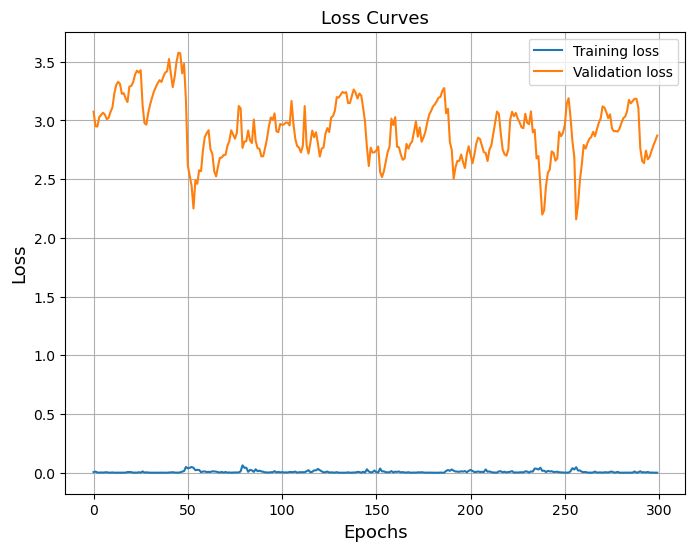

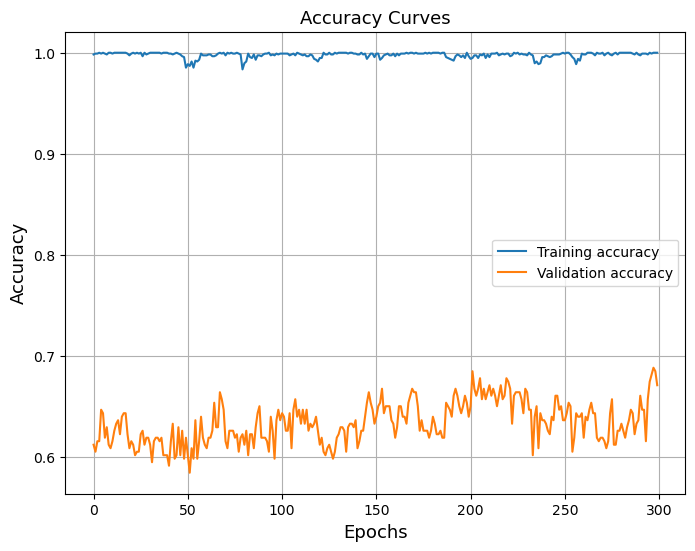

In [15]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss and accuracy curves for training and validation metrics.
    Args:
        history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.xlabel('Epochs', fontsize=13)
    plt.ylabel('Loss', fontsize=13)
    plt.title('Loss Curves', fontsize=13)
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, accuracy, label='Training accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    plt.xlabel('Epochs', fontsize=13)
    plt.ylabel('Accuracy', fontsize=13)
    plt.title('Accuracy Curves', fontsize=13)
    plt.legend()
    plt.grid(True)

# Sử dụng hàm này với đối tượng history của mô hình
plot_loss_curves(history)


In [16]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10/10 [==============================] - 1s 107ms/step - loss: 2.8718 - accuracy: 0.6713
Test loss: 2.8718113899230957
Test accuracy: 0.6712802648544312


In [17]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

10/10 [==============================] - 13s 147ms/step
              precision    recall  f1-score   support

    artifact       0.85      0.85      0.85        34
    extrahls       0.71      0.59      0.65        17
  extrastole       0.17      0.25      0.20        12
      murmur       0.52      0.69      0.59        61
      normal       0.77      0.67      0.72       165

    accuracy                           0.67       289
   macro avg       0.61      0.61      0.60       289
weighted avg       0.70      0.67      0.68       289



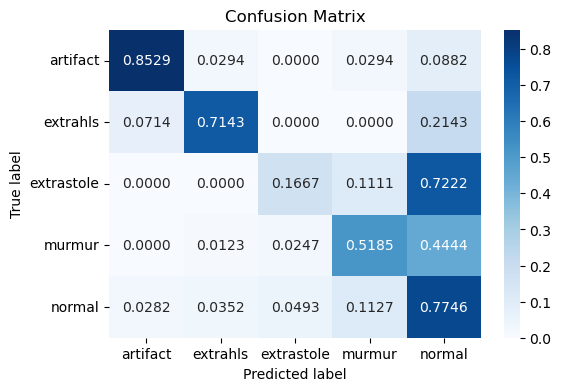

In [18]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Class names
class_names = ['artifact', 'extrahls', 'extrastole', 'murmur', 'normal']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by dividing each row by its sum
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Function to plot the confusion matrix
def plot_confusion_matrix(cm_normalized, class_names, figsize=(6, 4), fmt='.4f'):
    plt.figure(figsize=figsize)
    sns.heatmap(cm_normalized, annot=True, fmt=fmt, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names)
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)
    plt.show()

# Plot the normalized confusion matrix with class names
class_names = encoder.classes_
plot_confusion_matrix(cm_normalized, class_names)


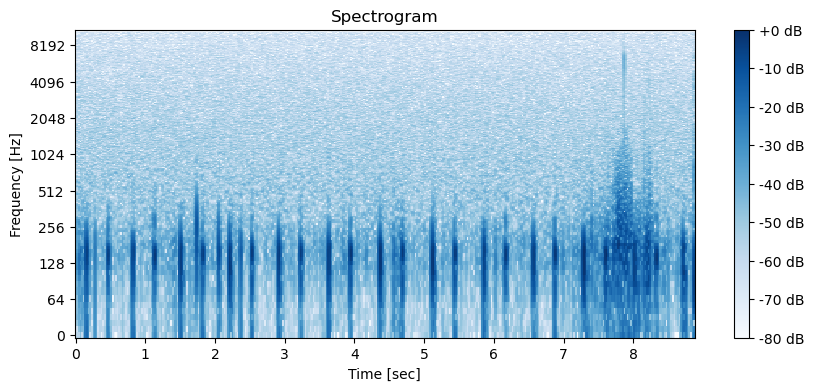

In [41]:

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load an audio file
y, sr = librosa.load('Heartbeat_Sounds/set_a/normal__201101070538.wav')  # Replace with the path to your file

# Compute the spectrogram
S = np.abs(librosa.stft(y))

# Convert to decibels
D = librosa.amplitude_to_db(S, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='Blues')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()




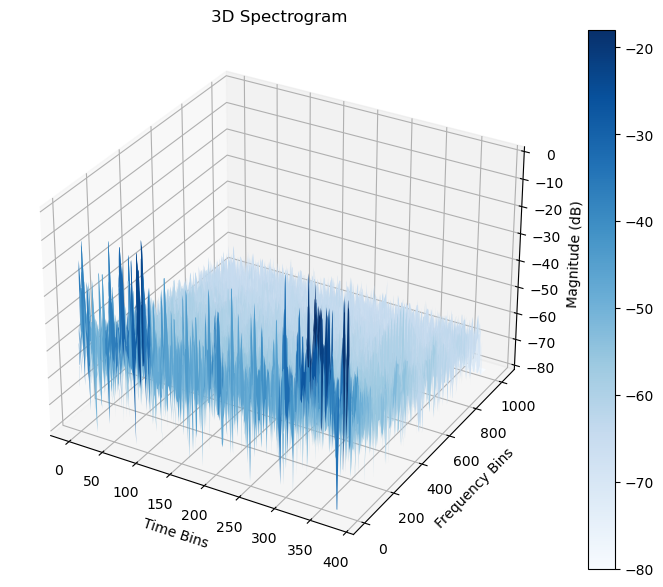

In [42]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load an audio file
y, sr = librosa.load('Heartbeat_Sounds/set_a/normal__201101070538.wav')  # Replace with the path to your file

# Compute the STFT of the signal
S = np.abs(librosa.stft(y))

# Convert to decibels
D = librosa.amplitude_to_db(S, ref=np.max)

# Create time and frequency bins for plotting
time_bins = np.arange(D.shape[1])
frequency_bins = np.arange(D.shape[0])

# Create meshgrid for plotting
T, F = np.meshgrid(time_bins, frequency_bins)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T, F, D, cmap='Blues')

ax.set_title('3D Spectrogram')
ax.set_xlabel('Time Bins')
ax.set_ylabel('Frequency Bins')
ax.set_zlabel('Magnitude (dB)')
fig.colorbar(surf)
plt.show()


In [43]:
model_name = "heart_sound_2dcnn.h5"
model.save(model_name)